In [ ]:
# Inverse Radial Distortion
> How to find the inverse of a radial distortion function.

- toc: true 
- badges: true
- comments: true
- categories: [Optimisation, Computer Vision]
- image: images/2020-04-05-Inverse-Radial-Distortion/header.png

In [1]:
import numpy as np 
import json

import matplotlib.pyplot as plt 

from scipy.optimize import least_squares
from scipy.interpolate import griddata
import cv2

from PIL import Image

plt.rcParams["figure.figsize"] = (20,20)

In [2]:
sensor_width_pixels = 1500
sensor_height_pixels = 1000
focal_length_pixels = 1000 #inital estimate

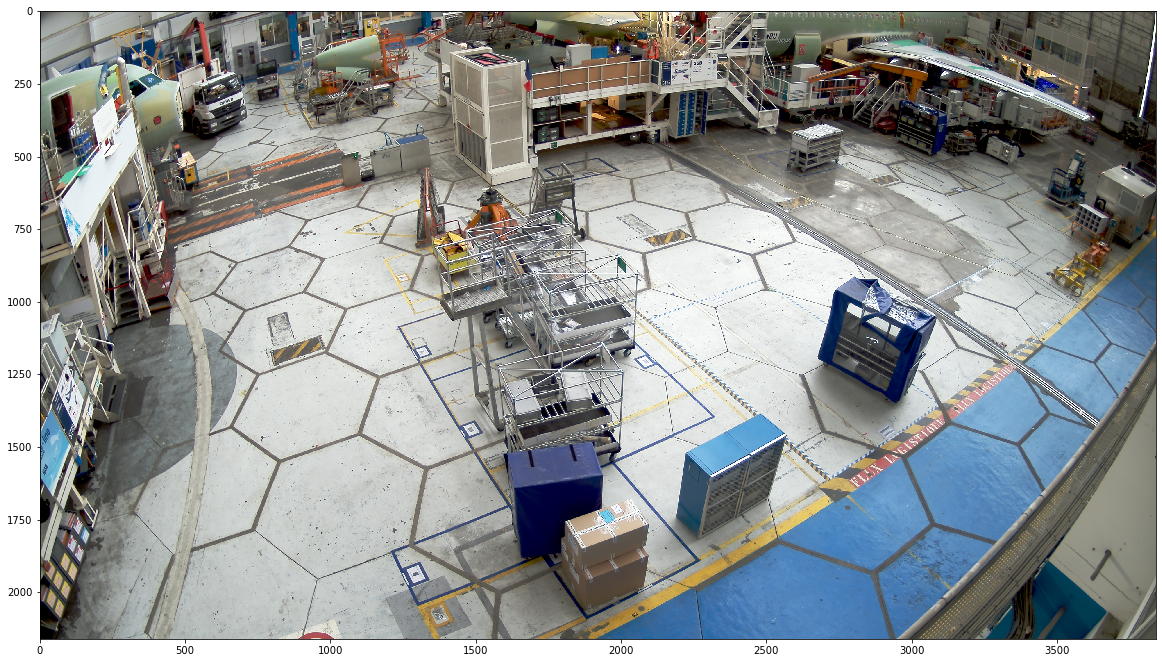

In [3]:
img = np.asarray(Image.open('CAM1.jpg'))

plt.imshow(img)
plt.show()

In [4]:
JSON = json.loads(open('CAM1.json','r').read())

lines = []
for shape in JSON['shapes']:
    line = shape['points']
    if len(line)==3:
        line = np.asarray(line,dtype=np.float64)
        line[:,0]-= 0.5*sensor_width_pixels
        line[:,1]-= 0.5*sensor_height_pixels
        lines.append(line)

    else:
        print(line)

lines = np.asarray(lines,dtype=np.float64)

[[1579, 2000], [1051, 1024], [780, 362], [781, 361]]
[[2868, 1933], [3365, 1492], [3776, 1028], [3776, 1028]]


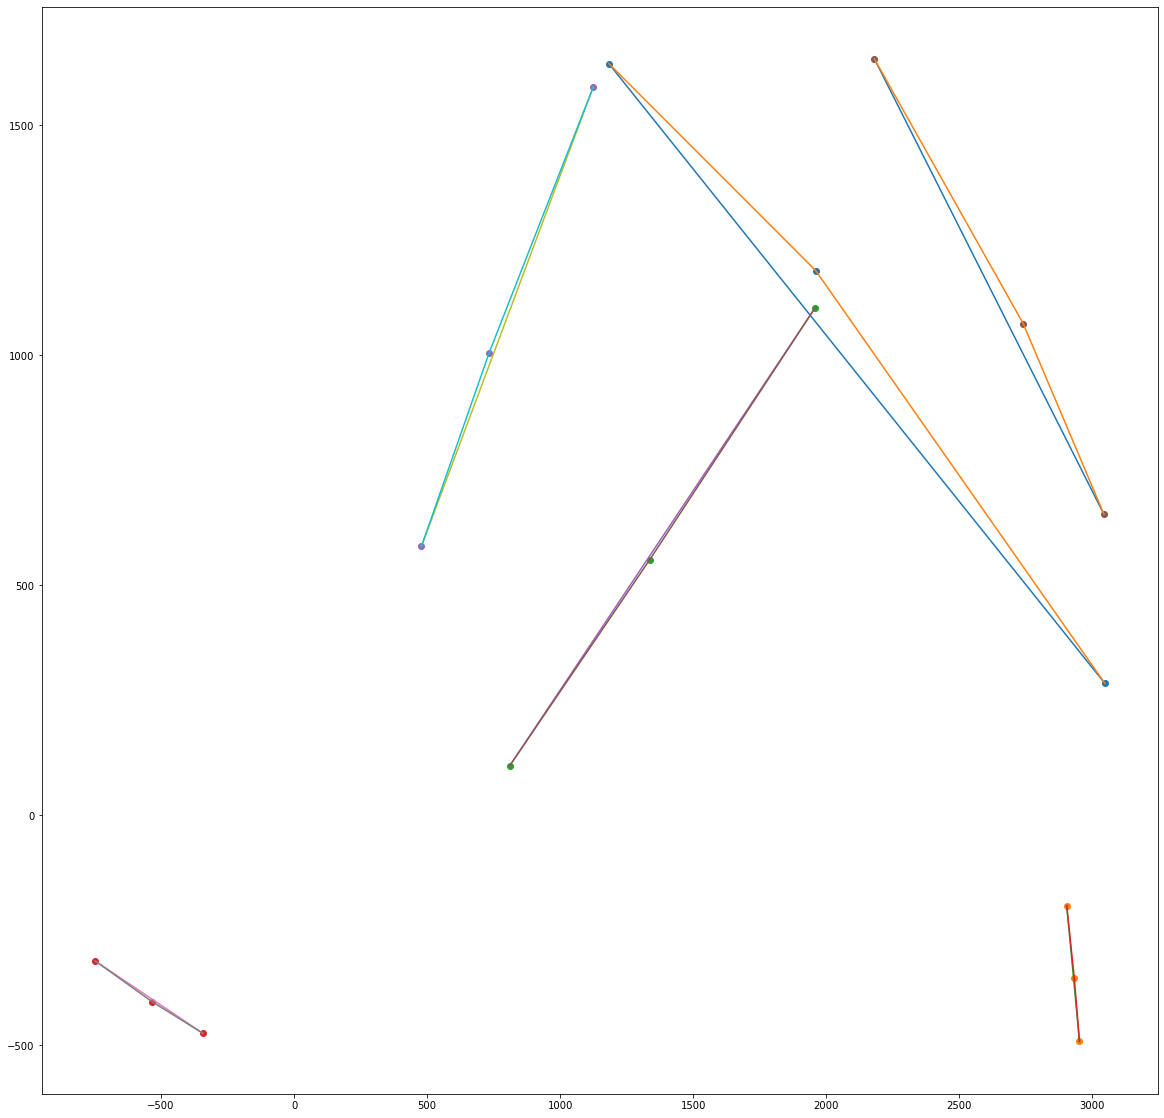

In [11]:
labels = []
i = 0
for line in lines:
    us = []
    vs = []
    for pt in line:
        us.append(pt[0])
        vs.append(pt[1])
    
    plt.plot([us[0],us[2]],[vs[0],vs[2]])
    plt.plot(us,vs)
    
    plt.scatter(us,vs)
plt.show()

In [6]:
def line_point_distance(line):
    [a,c,b] = line
    AB = b-a
    AC = c-a
    distance = np.linalg.norm(np.cross(AC,AB))/np.linalg.norm(AB)
    return(distance)


#Just as a test!
line = np.array([[0,0],[1,1337],[2,0]])
distance = line_point_distance(line)
print(distance)


1337.0


In [7]:
def map_points(points,k):
    k_1, k_2, k_3 = k
    points/= 2000.0
    r = np.sqrt(np.sum(points**2, axis=1))
    r_adjust = 1 + k_1 * r + k_2 * r**2 + k_3 * r**3
    points *= r_adjust[:, np.newaxis]
    points *= 2000.0
    return(points)

In [8]:
def fun(k,lines,focal_length_pixels):
    print(k)
    
    distances = []
    for line in lines:
        line = map_points(line,k)
        distances.append(line_point_distance(line))
    distances = np.array(distances,dtype=np.float64)
    return(distances)


In [9]:
x0 = np.array([1e-6,1e-6,1e-6],dtype=np.float64)
res = least_squares(fun, x0,  verbose=1, x_scale='jac', ftol=1e-4, method='lm',loss='linear',args=(lines,focal_length_pixels))




[1.e-06 1.e-06 1.e-06]
[1.e-06 1.e-06 1.e-06]
[1.e-06 1.e-06 1.e-06]
[1.00000001e-06 1.00000000e-06 1.00000000e-06]
[1.00000000e-06 1.00000001e-06 1.00000000e-06]
[1.00000000e-06 1.00000000e-06 1.00000001e-06]
[-1.88038008e-04  1.53754551e-04 -3.78238613e-05]
[-1.88038005e-04  1.53754551e-04 -3.78238613e-05]
[-1.88038008e-04  1.53754553e-04 -3.78238613e-05]
[-1.88038008e-04  1.53754551e-04 -3.78238607e-05]
[-2.07935751e-04  6.24884537e-05 -2.15200739e-05]
[-2.07935748e-04  6.24884537e-05 -2.15200739e-05]
[-2.07935751e-04  6.24884546e-05 -2.15200739e-05]
[-2.07935751e-04  6.24884537e-05 -2.15200736e-05]
[-1.35055844e-04  3.30665589e-05 -1.72787303e-05]
[-1.74987610e-04  4.50736106e-05 -1.86578639e-05]
[-1.98425628e-04  5.21211720e-05 -1.94673491e-05]
[-2.13972893e-04  5.78012387e-05 -2.02352426e-05]
[-2.10924705e-04  6.01677935e-05 -2.08842466e-05]
[-2.09429383e-04  6.13287093e-05 -2.12026172e-05]
[-2.08681880e-04  6.19090436e-05 -2.13617686e-05]
[-2.08329425e-04  6.21826767e-05 -2.1436

In [10]:
k_1 = res.x[0]
k_2 = res.x[1]
k_3 = res.x[2]


labels = []
i = 0
for line in lines:
    line = map_points(line,k_1,k_2,k_3)
    us = line[:,0]
    vs = line[:,1]
    plt.plot([us[0],us[2]],[vs[0],vs[2]])
    plt.plot(us,vs)
    
    plt.scatter(us,vs)
plt.show()



TypeError: map_points() takes 2 positional arguments but 4 were given

In [ ]:
xs = []
ys = []

i_list = []
j_list = []

map_x = np.zeros((sensor_height_pixels,sensor_width_pixels), dtype=np.float32)
map_y = np.zeros((sensor_height_pixels,sensor_width_pixels), dtype=np.float32)

for i in range(0,sensor_width_pixels):
     for j in range(0,sensor_height_pixels):
        pt = [i,j]
        x,y = map_points(pt,k_1,k_2,k_3)
        map_x[j,i] = x
        map_y[j,i] = y
        
        xs.append(x)
        ys.append(y)




In [ ]:
#Invert Map
points =  np.stack([map_x.flatten(), map_y.flatten()], axis=1)
grid = np.mgrid[:map_x.shape[0], :map_y.shape[1]]
values = grid.reshape(2, -1).T[..., ::-1] 
grid_y, grid_x = grid
map_back = griddata(points, values, (grid_x, grid_y), method='cubic').astype(np.float32)


In [ ]:
#Map image to undistort

img = np.asarray(Image.open('Versailles.png'))

In [ ]:
mapped_img = cv2.remap(img, map_back[:,:,0], map_back[:,:,1],  cv2.INTER_LINEAR)

In [ ]:
plt.imshow(mapped_img)
plt.show()